# Set up

In [ ]:
import os

import numpy as np
import random as rd
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

In [36]:
!unzip /content/yalefaces.zip

Archive:  /content/yalefaces.zip
replace yalefaces/person-4/rightlight? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Reading traning image

In [37]:
base_dir = 'yalefaces'
person_folders = [
    'person-1',
    'person-2',
    'person-3',
    'person-4',
    'person-5',
    'person-6',
    'person-7',
    'person-8',
    'person-9',
    'person-10',
    'person-11',
    'person-12',
    'person-13',
    'person-14',
    'person-15',
]

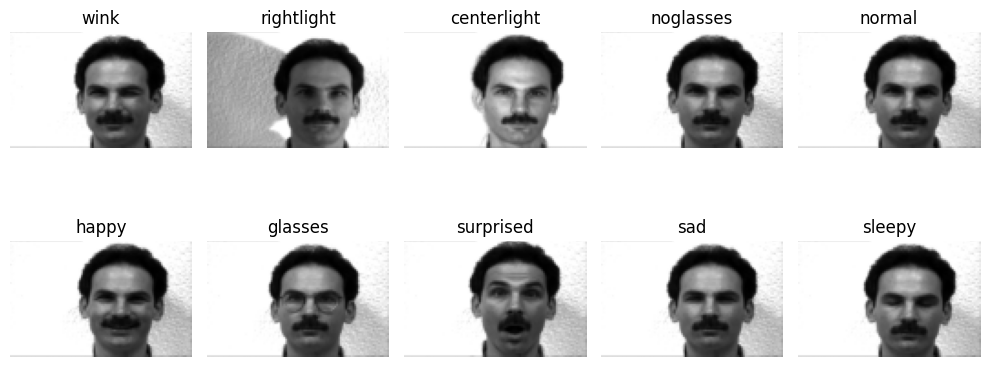

In [38]:
# Choose randomly 1 person to display
person_folder = rd.choice(person_folders)

plt.figure(figsize=(10,5))

for i, filename in enumerate(os.listdir(os.path.join(base_dir, person_folder))):
      # Create image path
      image_path = os.path.join(base_dir, person_folder, filename)

      #Reading image
      image = imread(image_path)
      image = image.squeeze(0)
      image = resize(image, (64, 100), anti_aliasing=True)

      # Plot image
      plt.subplot(2, 5, i + 1)
      plt.imshow(image, cmap='gray')
      plt.axis('off')
      plt.title(filename)

plt.tight_layout()
plt.show()

In [39]:
# Get data
data= {}

for folder in person_folders:
  for filename in os.listdir(os.path.join(base_dir, folder)):
    image_path = os.path.join(base_dir, folder, filename)
    image = imread(image_path)
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if folder not in data:
      data[folder]  = [image]
    else:
      data[folder].append(image)

for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10,-1)

# PCA (Principle Components Analysis)

In [40]:
# Standardlizing images
def Standardlize (image: np.ndarray) -> np.ndarray:
  image = (image - image.mean()) / image.std()
  image = image.astype(np.float32)

  return image

In [41]:
class PCA:
    def __init__(self, n_components: int = 5):
        self.n_components = n_components
        self.mean = None
        self.W = None
        self.values = None

    def fit(self, X: np.ndarray):

        self.mean = np.mean(X, axis=0)
        X = Standardlize(X)
        cov = (X.T @ X)/(X.shape[0]-1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Change signs
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[1])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]

        # Sort eigen pair (descending)
        sorted_index = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_index]
        eigenvectors = eigenvectors[:, sorted_index]

        self.values = eigenvalues[:self.n_components]
        self.W = eigenvectors[:, :self.n_components].T

    def transform(self, X: np.ndarray) -> np.ndarray:
        return self.W @ X

    def inverse_transform(self, X: np.ndarray) -> np.ndarray:
        return (X @ self.W) + self.mean

# Approximating the Principle Space

In [42]:
PCA = PCA(n_components=20)

In [43]:
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis = 0)
images.shape

(150, 5120)

In [44]:
PCA.fit(images)

In [45]:
PCA.W.shape

(20, 5120)

# Visualize the base of this Principle Space

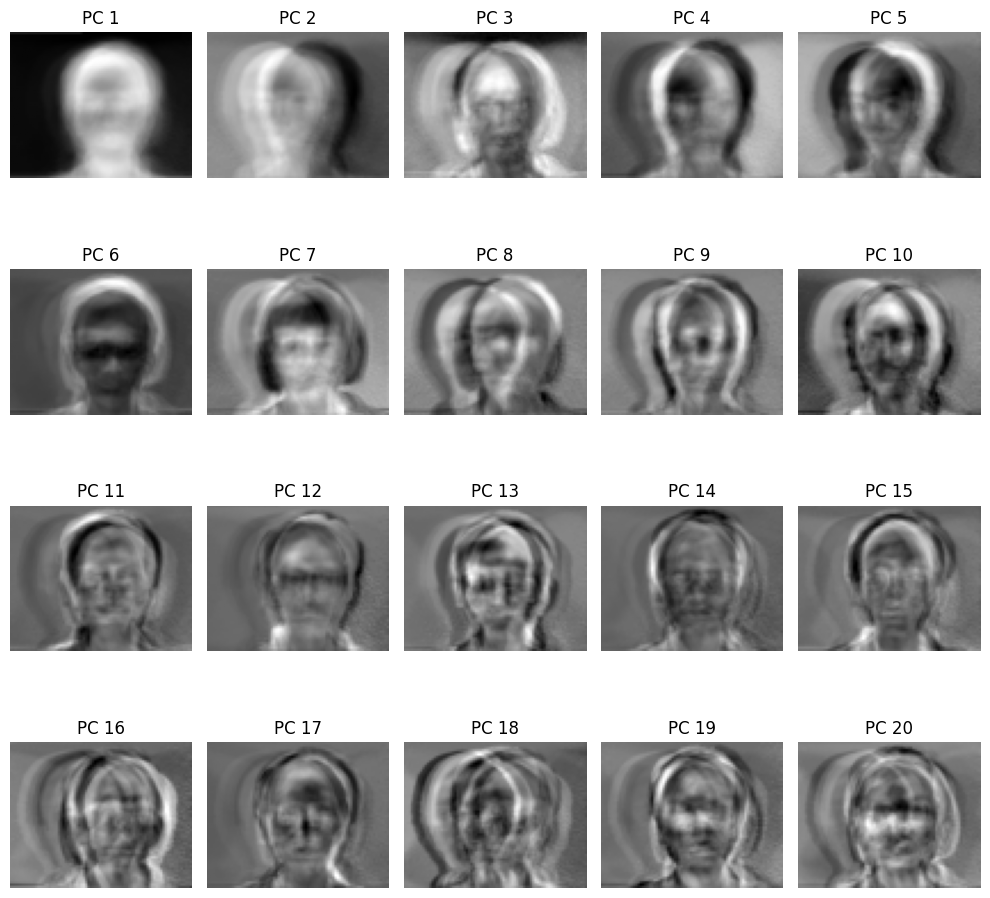

In [46]:
eigenfaces = PCA.W.reshape(20, 64, 80)

plt.figure(figsize=(10, 10))

for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4, 5, ith + 1)

    # Chuẩn hóa lại giá trị pixel
    eigenface_normalized = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())

    plt.imshow(eigenface_normalized, cmap='gray')
    plt.axis('off')
    plt.title(f"PC {ith+1}")

plt.tight_layout()
plt.show()

#### Finding the Mean Face

In [47]:
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data.items()
}

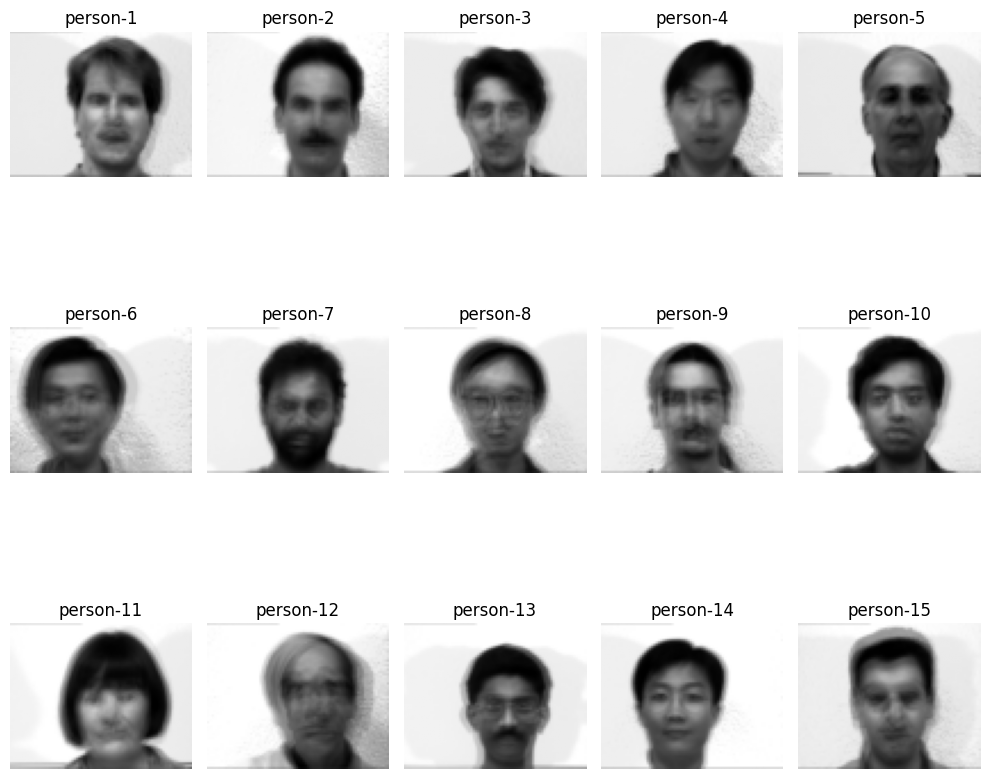

In [48]:
plt.figure(figsize=(10,10))
for ith, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)

    mean_face_normalized = (mean_face - mean_face.min()) / (mean_face.max() - mean_face.min())

    plt.subplot(3, 5, ith + 1)
    plt.imshow(mean_face_normalized, cmap='gray')
    plt.axis('off')
    plt.title(person)

plt.tight_layout()
plt.show()

### Project the Mean face into the Principle Space

In [49]:
projected_mean_faces = {}
for person in mean_faces:
    mean_face = mean_faces[person]
    projected_mean_faces[person] = PCA.transform(mean_face)

# Loading the Test Data

In [50]:
labels = []
test_images = []
test_dir = '/content/yalefaces/test'

for filename in os.listdir(test_dir):
    person_name = filename.split(".")[0]
    labels.append(person_name)

    image = imread(os.path.join(test_dir, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)

In [51]:
test_images = np.concat(test_images, axis= 0)
test_images.shape

(15, 64, 80)

# Assign persons to the face images in testing data

In [52]:
def euclide_distance(X: np.ndarray, Y: np.ndarray)->float:
  return ((X-Y)**2).sum()**0.5

In [53]:
predict = {}

for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = PCA.transform(image)
  min_distance = np.inf
  min_person = None

  for person in projected_mean_faces:
    mean_face = projected_mean_faces[person]
    distance = euclide_distance(mean_face, projected_face)

    if distance < min_distance:
      min_distance = distance
      min_person = person

  predict[label] = min_person

# Evaluate the accuracy of this face recognition system

In [54]:
EMs = []

for label in predict:
  EMs.append(label == predict[label])

In [55]:
print(f" Accuracy: {np.mean(EMs)*100:0.2f}%")

 Accuracy: 66.67%
